Fetching the dataset from kaggle

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!unzip drive/MyDrive/Tumor\ detection/BrainTumorClassification.zip -d /content

Archive:  drive/MyDrive/Tumor detection/BrainTumorClassification.zip
  inflating: /content/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/Testing/glioma_tumor/image(21).jpg  
  inflating: /content/Testing/glioma_tumor/imag

#**With self-made base**#

Import the required libraries

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import os, warnings
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

Set a seed for all random operations so that the code is reproducible always

In [4]:
def set_seed(seed=3141592):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

Set default matplotlib configuration

In [5]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
 # This will clean up all the output cells

Loading the training and testing datasets

In [6]:
ds_train_ = image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="training",
  labels='inferred',
  label_mode='categorical',
  image_size=[300,300],
  batch_size=32,
  shuffle=True,
  seed=123,
)

ds_val_ = image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  label_mode='categorical',
  image_size=[300,300],
  batch_size=32,
  shuffle=True,
  seed=123,
)

ds_test_ = image_dataset_from_directory(
    './Testing',
    labels='inferred',
    label_mode='categorical',
    image_size=[300,300],
    batch_size=32,
    shuffle=True,
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


Observing the dataset

Class Names : 

In [7]:
class_names = ds_train_.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Following are the 9 example images from the training dataset



In [8]:
plt.figure(figsize=(10, 10))

for i in range(len(class_names)):
    filtered_ds = ds_train_.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

ValueError: ignored

<Figure size 720x720 with 0 Axes>

Let us look at the shape of the input and output of training dataset

In [10]:
for image_batch, labels_batch in ds_train_:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32, 4)


In [11]:
'''
num_classes = len(class_names)
ds_train_ = ds_train_.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
ds_test_ = ds_test_.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
'''

'\nnum_classes = len(class_names)\nds_train_ = ds_train_.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))\nds_test_ = ds_test_.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))\n'

Above we can see that the training dataset is divided into batches of 64, with image size in input of 300x300 with 3 channels corresponding to RGB

The labels_batch variable represents the output and shows that there are 64 labels corresponding to 64 input images from each batch.

Now, we will configure the dataset for performance by using cache and prefetch.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train_.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val_.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test_.cache().prefetch(buffer_size=AUTOTUNE)

Now, we shall define the model below :

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

num_classes = len(class_names)

model = keras.Sequential([

    # Applying data augmentation so as to increase the training data size to 
    # improve generalization
    
    preprocessing.RandomRotation(factor=0.10, input_shape=((300, 300, 3))),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.experimental.preprocessing.Rescaling(1./255),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=5, filters=32, activation='relu', padding='same'),
    layers.MaxPool2D(),

    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=64, activation='relu', padding='same'),
    layers.MaxPool2D(),
    

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=128, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.BatchNormalization(renorm=True),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.3),
    
    layers.BatchNormalization(renorm=True),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.3),

    layers.BatchNormalization(renorm=True),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.3),

    layers.BatchNormalization(renorm=True),
    layers.Dense(num_classes, activation='softmax'),
])




In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 300, 300, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 300, 300, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 300, 300, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      2

Now we shall compile the model using the Adam optimizer

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now, we shall fit the model on the data

Adding early stopping callback

In [16]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)


In [17]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=80,
    callbacks=[early_stopping],
)

Epoch 1/80
72/72 [==============================] - 43s 305ms/step - loss: 2.6549 - accuracy: 0.3375 - val_loss: 1.2207 - val_accuracy: 0.4704
Epoch 2/80
72/72 [==============================] - 19s 264ms/step - loss: 1.5063 - accuracy: 0.4316 - val_loss: 0.9760 - val_accuracy: 0.6063
Epoch 3/80
72/72 [==============================] - 19s 268ms/step - loss: 1.1101 - accuracy: 0.5309 - val_loss: 0.9057 - val_accuracy: 0.6324
Epoch 4/80
72/72 [==============================] - 20s 275ms/step - loss: 1.0097 - accuracy: 0.5849 - val_loss: 0.8149 - val_accuracy: 0.7108
Epoch 5/80
72/72 [==============================] - 20s 280ms/step - loss: 1.2993 - accuracy: 0.5527 - val_loss: 0.7994 - val_accuracy: 0.6882
Epoch 6/80
72/72 [==============================] - 20s 277ms/step - loss: 0.9600 - accuracy: 0.6324 - val_loss: 0.6201 - val_accuracy: 0.7265
Epoch 7/80
72/72 [==============================] - 20s 275ms/step - loss: 0.8573 - accuracy: 0.6677 - val_loss: 0.5800 - val_accuracy: 0.7509

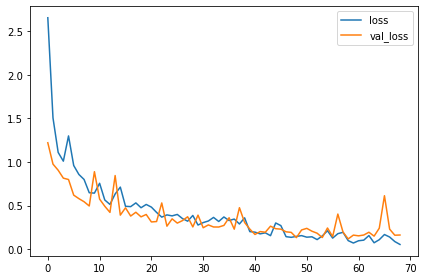

In [18]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()

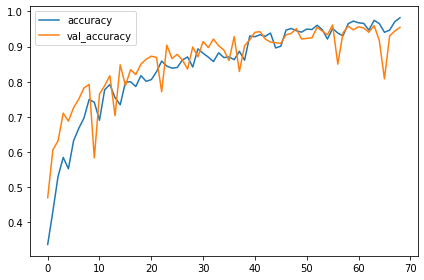

In [19]:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [20]:
print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));

Minimum Validation Loss: 0.1178


In [21]:
print("Maximum Validation Accuracy: {:0.4f}".format(history_frame['val_accuracy'].max()));

Maximum Validation Accuracy: 0.9617


In [22]:
pred = model.predict(ds_test)
pred = np.argmax(pred,axis=1)

In [23]:
print((pred))

[0 2 3 3 2 1 2 1 1 1 3 2 2 2 0 1 1 2 1 0 3 2 2 1 1 2 1 1 1 3 2 1 1 1 1 1 1
 0 2 2 1 2 3 1 1 2 1 3 3 1 2 1 2 1 1 1 2 2 1 2 2 2 1 1 2 1 1 2 2 1 3 1 2 2
 1 2 2 1 2 1 2 2 1 2 2 1 3 2 1 1 1 3 2 2 1 2 3 2 1 2 2 1 1 1 2 3 1 0 2 3 2
 1 2 0 2 2 2 2 2 2 2 3 2 2 2 1 1 2 1 1 1 3 0 1 1 2 2 1 3 1 3 1 2 2 2 1 1 1
 2 3 1 2 2 1 3 2 1 1 2 3 3 2 1 3 2 1 1 2 1 1 3 2 1 0 3 2 1 1 0 0 3 2 1 1 1
 1 0 1 2 3 2 1 1 0 2 1 1 1 3 2 2 1 2 3 1 1 2 1 2 2 3 2 1 1 1 1 0 2 1 3 2 3
 1 2 2 2 2 2 2 1 1 1 3 2 1 2 1 2 1 1 2 3 1 3 3 1 1 1 1 3 1 3 2 3 1 1 2 2 0
 1 1 2 1 2 2 0 2 2 2 1 2 1 3 3 3 1 0 0 1 1 2 2 2 1 2 3 2 1 2 2 1 2 1 1 2 0
 1 1 2 2 3 2 1 2 1 3 1 2 3 3 3 1 3 3 1 1 1 2 1 2 2 2 2 0 1 1 3 1 2 1 1 0 1
 2 2 0 2 3 1 2 1 2 1 1 1 2 1 1 3 1 1 1 2 2 2 1 1 1 3 1 1 1 3 0 1 3 1 1 1 2
 1 2 1 1 1 2 1 0 1 2 3 3 1 0 2 2 2 1 1 2 3 1 2 2]


In [25]:
model.save("BrainTumorClassification")

INFO:tensorflow:Assets written to: BrainTumorClassification/assets


In [27]:
!cp -r BrainTumorClassification drive/MyDrive/Tumor\ detection

In [24]:
x = np.array()
for image_batch, labels_batch in ds_test:
  x = np.concatenate(x, labels_batch.numpy())
print(x)

TypeError: ignored